In [6]:
import array
import random
import numpy as np
import numpy
import math
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import pickle
import array
from utils.bezier_parametrization import BezierAirfoil
from utils.xfoil_adapter import XFoilAdapter

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

SEED = 42
CONTROL_POINTS_SHAPE=(6,6)
FREQ = 10
NGEN = 150
MU = 100
CXPB = 0.9

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_UP, BOUND_LOW  = BezierAirfoil.get_bounds(CONTROL_POINTS_SHAPE)

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = BezierAirfoil.parameters_required_for_shape(CONTROL_POINTS_SHAPE)

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

def evaluate(individual):
    with XFoilAdapter() as xfoil:
        # xfoil.set_airfoils(airfoils=[airfoil])
        # xfoil.set_run_condition(
        #     reynolds=3e6,
        #     mach=0,
        #     alphas=[8],
        # )
        try:
            airfoil = BezierAirfoil(individual, shape=CONTROL_POINTS_SHAPE)
            # results = xfoil.run()
            # # We have only one run, so we can just take the first element
            # run_results = results[0][0].get('result', None)
            # print(run_results)
            # if run_results is None:
            #     return 1000, 0
            # cl = run_results['CL'][0]
            # cd = run_results['CD'][0]
            return individual[0]+individual[1], individual[0]*individual[1]
        except Exception as e:
            print(e)
            return 1000, 0

toolbox.register("attr_float", BezierAirfoil.random_params_initializer, shape=CONTROL_POINTS_SHAPE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)



def main(seed=None, checkpoint=None):
    if checkpoint:
        # A file name has been given, then load the data from the file
        try:
            with open(checkpoint, "rb") as cp_file:
                cp = pickle.load(cp_file)
                population = cp["population"]
                start_gen = cp["generation"]
                pareto = cp["pareto"]
                logbook = cp["logbook"]
                random.setstate(cp["rndstate"])
                np.random.set_state(cp["nprndstate"])
        except FileNotFoundError:
            print("Checkpoint not found. Starting a new run.")
            return main(seed=seed)
    else:
        random.seed(seed)
        np.random.seed(seed)
        # Start a new evolution
        population = toolbox.population(n=MU)
        start_gen = 0
        pareto = tools.ParetoFront()
        logbook = tools.Logbook()
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        logbook = tools.Logbook()
        logbook.header = "gen", "evals", "std", "min", "avg", "max"
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    population = toolbox.select(population, len(population))

    # stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    # Begin the generational process
    for gen in range(start_gen, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        population = toolbox.select(population + offspring, MU)
        pareto.update(population)
        record = stats.compile(population)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)
        if gen % FREQ == 0 or gen == NGEN - 1:
            # Fill the dictionary using the dict(key=value[, ...]) constructor
            cp = dict(population=population, generation=gen, pareto=pareto,
                      logbook=logbook, rndstate=random.getstate(), nprndstate=np.random.get_state())

            with open(f"checkpoint_name_gen_{gen}.pkl", "wb") as cp_file:
                pickle.dump(cp, cp_file)

    print("Final population hypervolume is %f" % hypervolume(population, [11.0, 11.0]))

    return population, logbook


/Users/hugo/Developer/python/tcc/.venv/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/hugo/Developer/python/tcc/.venv/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [7]:
population, stats = main(seed=SEED)
print(stats)
# print("Convergence: ", convergence(pop, optimal_front))
# print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))


gen	evals	std                            	min                            	avg                            	max                            
0  	100  	[3.03607864e-03 2.38621822e-06]	[6.21430870e-05 5.83461352e-10]	[5.03758358e-03 2.92374269e-06]	[1.12852285e-02 9.52215178e-06]
1  	100  	[3.02166724e-03 2.75443545e-06]	[6.21430870e-05 5.83461352e-10]	[4.39202576e-03 2.95964972e-06]	[1.08370200e-02 1.00790544e-05]
2  	100  	[2.84729620e-03 2.72165948e-06]	[6.21430870e-05 5.83461352e-10]	[3.74518011e-03 2.60841062e-06]	[1.083702e-02 1.079995e-05]    
3  	100  	[2.69428230e-03 2.80975269e-06]	[6.21430870e-05 5.83461352e-10]	[3.24123005e-03 2.38932948e-06]	[1.06021688e-02 1.12627721e-05]
4  	100  	[2.33223544e-03 2.82948434e-06]	[5.96154704e-05 8.77497719e-10]	[2.77185083e-03 2.10847790e-06]	[9.74860616e-03 1.22852244e-05]
5  	100  	[2.82247790e-03 3.61969299e-06]	[4.86872419e-05 3.58654925e-10]	[3.14030155e-03 2.66547177e-06]	[1.40370396e-02 1.86016884e-05]
6  	100  	[2.89789633e-03 3.895172

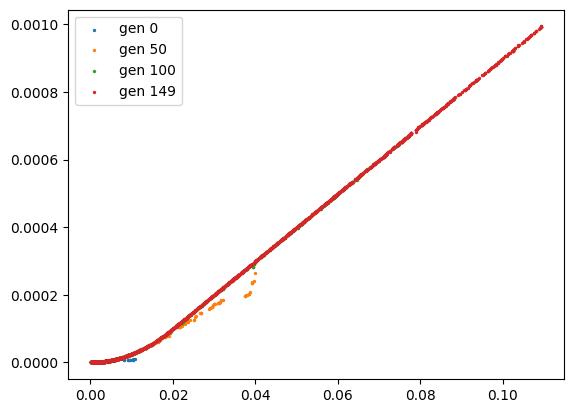

In [8]:
from matplotlib import pyplot as plt

def print_pop():
    gens = [0, 50, 100, 149]
    fig, ax = plt.subplots()
    for gen in gens:        
        with open(f"checkpoint_name_gen_{gen}.pkl", "rb") as cp_file:
            cp = pickle.load(cp_file)
            population = cp["population"]
            pareto = cp["pareto"]
            front = numpy.array([ind.fitness.values for ind in pareto])
            ax.scatter(front[:,0], front[:,1], s=2, label=f"gen {gen}")

    ax.legend()
    plt.show()

print_pop()

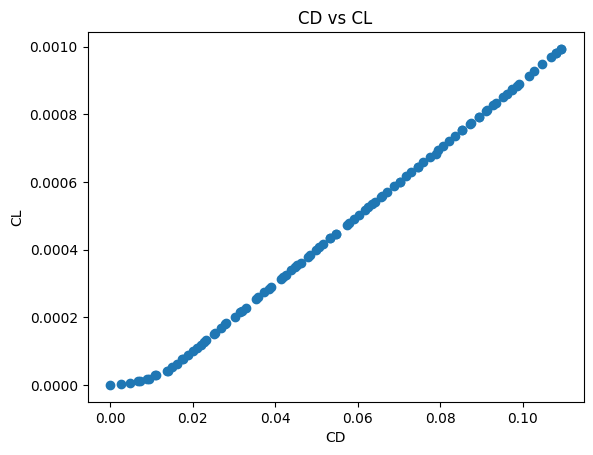

In [9]:

import matplotlib.pyplot as plt
import numpy
front = numpy.array([ind.fitness.values for ind in population])
# optimal_front = numpy.array(optimal_front)
# plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
cd = front[:, 0]
cl = front[:, 1]
fig, ax = plt.subplots()
ax.scatter(cd, cl)
ax.set_xlabel("CD")
ax.set_ylabel("CL")
ax.set_title("CD vs CL")
plt.show()

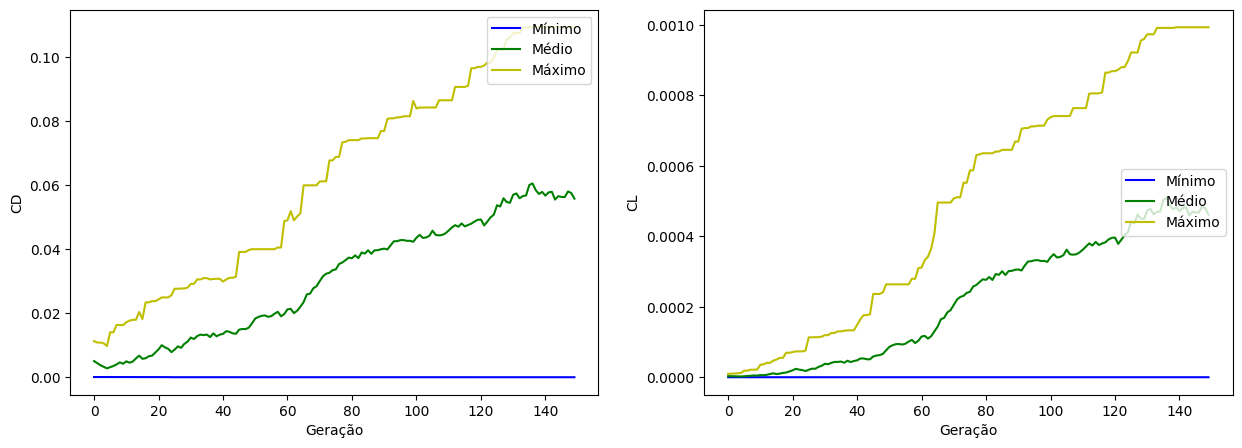

In [10]:
gen = stats.select("gen")
fit_avgs = stats.select("avg")
fit_mins = stats.select("min")
fit_maxes = stats.select("max")

cl_fits_avgs = [fit_avg[0] for fit_avg in fit_avgs]
cd_fits_avgs = [fit_avg[1] for fit_avg in fit_avgs]

cl_fits_mins = [fit_min[0] for fit_min in fit_mins]
cd_fits_mins = [fit_min[1] for fit_min in fit_mins]

cl_fits_maxes = [fit_max[0] for fit_max in fit_maxes]
cd_fits_maxes = [fit_max[1] for fit_max in fit_maxes]

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax1 = axs[0]
ax2 = axs[1]
line1 = ax1.plot(gen, cl_fits_mins, "b-", label="Mínimo")
line21 = ax2.plot(gen, cd_fits_mins, "b-", label="Mínimo")
ax1.set_xlabel("Geração")
ax1.set_ylabel("CD")
ax2.set_xlabel("Geração")
ax2.set_ylabel("CL")

# for tl in ax1.get_yticklabels():
#     tl.set_color("b")

# ax2 = ax1.twinx()
# line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
# ax2.set_ylabel("Size", color="r")
# for tl in ax2.get_yticklabels():
#     tl.set_color("r")

line2 = ax1.plot(gen, cl_fits_avgs, "g-", label="Médio")
line22 = ax2.plot(gen, cd_fits_avgs, "g-", label="Médio")

line3 = ax1.plot(gen, cl_fits_maxes, "y-", label="Máximo")
line23 = ax2.plot(gen, cd_fits_maxes, "y-", label="Máximo")

lns = line1 + line2 + line3
lns2 = line21 + line22 + line23
labs = [l.get_label() for l in lns]
labs2 = [l.get_label() for l in lns2]
ax1.legend(lns, labs, loc="upper right")
ax2.legend(lns2, labs2, loc="center right")

plt.show()